# Importing libraries

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-08-20 01:06:40.450863: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-08-20 01:06:40.491391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-20 01:06:40.491945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-08-20 01:06:40.492219: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-20 01:06:40.494309: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-20 01:06:40.496039: I tensorflow/st

If uncommented it will print all the log information about where the tensorflow operations were performed, in the CPU or the GPU

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

# Loading the train data set

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [4]:
def my_crop(img, start_y, start_x, desired_height, desired_width):
  if K.image_data_format() == 'channels_last':
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    dy = desired_height #input desired output size
    dx = desired_width #input desired output size
    # start_y = (height-dy)//2
    # start_x = (width-dx)//2
    return img[start_y:start_y+dy, start_x:(dx+start_x), :]
  else:
      assert img.shape[0] == 3
      dy = desired_height #input desired output size
      dx = desired_width #input desired output size
      # start_y = (height-dy)//2
      # start_x = (width-dx)//2
      return img[:,start_y:start_y + dy, start_x:(dx + start_x)]

def crop_augmented_generator(batches, start_y, start_x, crop_height, crop_width):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the labels
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
    
      if K.image_data_format() == 'channels_last':
        # print("type of batch_x: ", type(batch_x))
        # print("type of batch_y: ", type(batch_y))
        # print("len of batch_x: ", len(batch_x))

        # Either batch_x or batch_y could be augmented or original
        batch_crops_input_x = np.zeros((batch_x[0].shape[0], crop_height, crop_width, 3))
        batch_crops_target_x = np.zeros((batch_x[1].shape[0], crop_height, crop_width, 3))

        batch_crops_input_y = np.zeros((batch_y[0].shape[0], crop_height, crop_width, 3))
        batch_crops_target_y = np.zeros((batch_y[1].shape[0], crop_height, crop_width, 3))
      else:
        # Either batch_x or batch_y could be augmented or original
        batch_crops_input_x = np.zeros((batch_x[0].shape[0], 3, crop_height, crop_width))
        batch_crops_target_x = np.zeros((batch_x[1].shape[0], 3, crop_height, crop_width))

        batch_crops_input_y = np.zeros((batch_y[0].shape[0], 3, crop_height, crop_width))
        batch_crops_target_y = np.zeros((batch_y[1].shape[0], 3, crop_height, crop_width))

      for i in range(batch_x[0].shape[0]):
        #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
        batch_crops_input_x[i] = my_crop(batch_x[0][i], start_y, start_x, crop_height, crop_width)
        batch_crops_target_x[i] = my_crop(batch_x[1][i], start_y, start_x, crop_height, crop_width)

        batch_crops_input_y[i] = my_crop(batch_y[0][i], start_y, start_x, crop_height, crop_width)
        batch_crops_target_y[i] = my_crop(batch_y[1][i], start_y, start_x, crop_height, crop_width)
      
      # print(type(batch_crops_input_x))
      batch_crops_x = (batch_crops_input_x, batch_crops_target_x)
      batch_crops_y = (batch_crops_input_y, batch_crops_target_y)

      yield (batch_crops_x, batch_crops_y)

  
    
def crop_generator(batches, start_y, start_x, crop_height, crop_width, flag=0):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the labels
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
      if flag==0:
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
          batch_crops_y = np.zeros((batch_y.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
          batch_crops_y = np.zeros((batch_y.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
            batch_crops_y[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
        yield (batch_crops, batch_crops_y)
      else: 
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)

        yield (batch_crops, batch_y)
         

In [5]:
# batch_size = 64
batch_size = 10
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",          # For work laptop
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    
    )

Found 295 images belonging to 1 classes.


In [6]:
validation_generator_for_training = datagen.flow_from_directory(
    "../../Images/june5Night/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 20 images belonging to 1 classes.


In [7]:
validation_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Validation/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )

Found 30 images belonging to 2 classes.


In [8]:
test_set_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Creating the cropped images

In [9]:
HEIGHT = 160
WIDTH = 128

In [10]:
train_crops = crop_generator(train_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
val_crops = crop_generator(validation_generator_for_training, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
test_crops = crop_generator(test_set_generator, 65, 69, HEIGHT,WIDTH,1)      # top, left, height, width
val_crops_for_threshold = crop_generator(validation_generator, 65, 69, HEIGHT,WIDTH,1)      # top, left, height, width

Here we make sure that both of the returned elements of the cropped generator, that is "imgaes_in_batch" and "imgaes_in_batch2", are indeed cropped images.

In [11]:
images_in_batch, images_in_batch2 = next(train_crops)

In [12]:
print(images_in_batch.shape)
print(images_in_batch2.shape)

(10, 160, 128, 3)
(10, 160, 128, 3)


In [13]:
single_input_image = images_in_batch[0]
single_expected_image = images_in_batch2[0]
print(single_input_image.shape)
print(single_expected_image.shape)

(160, 128, 3)
(160, 128, 3)


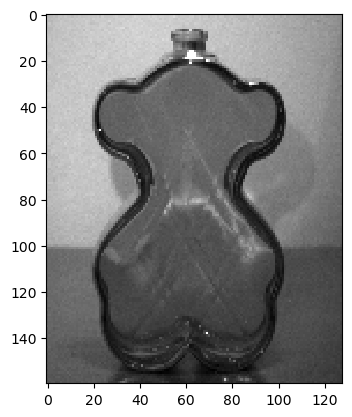

In [14]:
plt.imshow(single_input_image)

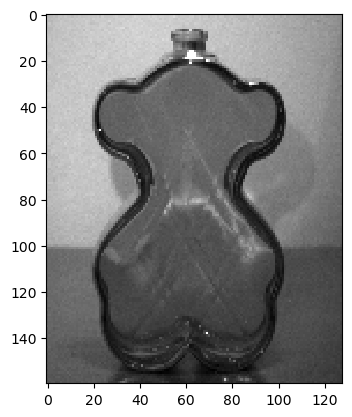

In [15]:
plt.imshow(single_expected_image)

In [16]:
compareImgs = single_input_image==single_expected_image
res1 =  np.all(compareImgs)
print("This is comparisson imgs:", res1)

This is comparisson imgs: True


# Building the model Autoencoder model

In [17]:
latent_dim = 40  # Number of latent dimension parameters

input_img = Input(shape=(HEIGHT, WIDTH, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(80, activation='relu')(x)        # Activation function is supposed to be none, i.e the output is the same as the input

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

2023-08-20 01:06:41.048730: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-08-20 01:06:41.069560: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-08-20 01:06:41.070315: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb7fc001050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-20 01:06:41.070346: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-20 01:06:41.140811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-20 01:06:41.141243: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5da2b30 initialized for platform CUDA (this does not guarantee that XLA will

(None, 10, 8, 1)
(None, 40)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (Non

In [18]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(10*8*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 784 total pixels
x = Dense(320, activation='sigmoid', name="original_decoder")(x)
x = Reshape((10,8,4),input_shape=(320,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 320)               13120     
_________________________________________________________________
original_decoder (Dense)     (None, 320)               102720    
_________________________________________________________________
reshape (Reshape)            (None, 10, 8, 4)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 8, 3)          111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 20, 16, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 16, 3)         84  

In [19]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mean_squared_error')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 16, 16)        0   

# Training the model

In [20]:
# # from tensorflow.keras.callbacks import EarlyStopping
# # run the modelvalidat
# # early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=5, mode='auto')
# history = ae.fit(train_crops, epochs=400, steps_per_epoch=len(train_generator), validation_data=val_crops, validation_steps =len(validation_generator_for_training),  verbose=1, shuffle = True)

In [21]:

# # Get the training and validation loss values from the history object
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Plot the training and validation loss
# epochs = range(1, len(train_loss) + 1)
# plt.plot(epochs, train_loss, 'b-', label='Training Loss')
# plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


Saving the train and validation history data

In [22]:
# # open file
# with open('txtFilesAutoencoderBottles4/TrainingLoss.txt', 'w+') as g:
#     # write elements of list
#     for items in train_loss:
#         g.write('%s\n' %items)
#     print("train_loss written successfully")
# # close the file
# g.close() 

# # open file
# with open('txtFilesAutoencoderBottles4/ValidationLoss.txt', 'w+') as g:
#     # write elements of list
#     for items in val_loss:
#         g.write('%s\n' %items)
#     print("val_loss written successfully")
# # close the file
# g.close()


LOading the train and validation history data

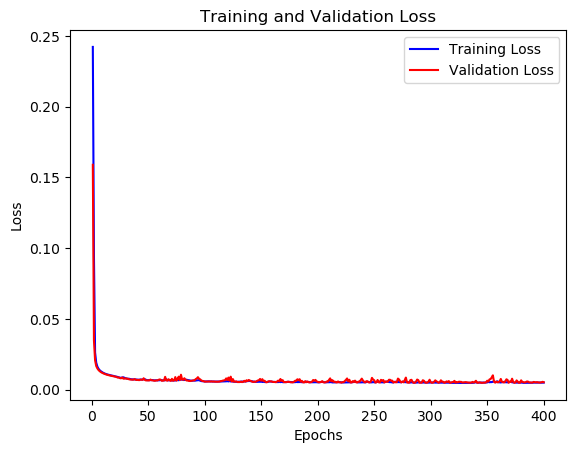

In [23]:
# Load data from the text file
with open("txtFilesAutoencoderBottles4/TrainingLoss.txt", "r") as file:
    train_loss_data = [float(line.strip()) for line in file]

# Load data from the text file
with open("txtFilesAutoencoderBottles4/ValidationLoss.txt", "r") as file:
    val_loss_data = [float(line.strip()) for line in file]

# Plot the training and validation loss
epochs = range(1, len(train_loss_data) + 1)
plt.plot(epochs, train_loss_data, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_data, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
filepath = "models/Bottles4_playground"

In [25]:
# ae.save(f"{filepath}")

Loading the model that was previously saved


In [26]:
# VAE model statement
model = Model(input_img,z_decoded)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 16, 16)        0   

In [27]:
model = keras.models.load_model(f'{filepath}')
print(type(model))

<class 'tensorflow.python.keras.engine.training.Model'>


# Quantifying the reconstruction error using "evaluate_generator()" function

Performing the computation of the reconstruction error of all the images in the training dataset. Computing the MSE of each image with its reconstructed version.

In [28]:
training_error = model.evaluate_generator(train_crops, steps=len(train_generator))
print("Recon. error for the training (non-anomaly) data is: ", training_error)

Instructions for updating:
Please use Model.evaluate, which supports generators.


2023-08-20 01:06:45.615904: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-20 01:06:45.828393: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


Recon. error for the training (non-anomaly) data is:  0.0055963024497032166


# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [29]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [31]:
total_rec_error = []
for i in range(len(train_generator)):                               #This will traverse the train generator the number of batches it contains
    images_in_batch, images_in_batch2 = next(train_crops)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function
    total_rec_error.append(calc_recon_error(images_in_batch))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")


1/1 [==============================] - 0s 806us/step - loss: 0.0055
The list of rec. error contains  30 batches of rec. errors


Above we can see, that it contains 30 batches and almost all of them includes 10 elements. Recall that the total number of images of the training dataset was 295. Hence in total we should have 295 error values. Let's convert it into a 295-length list.

In [33]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

295


In [34]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.0064290867439644826
The standard deviation of the errors list is:  0.0014733424917164725
The min value of the errors list is:  0.0047065624967217445
The max value of the errors list is:  0.014250707812607288


Above it can be seen that computing the model.evaluate_generator() function does NOT output the same as computing the error of each image one by one. We will use this last approach, the one by one error computation.

Gaphically, the distribution of the reconstruction error values is shown below:

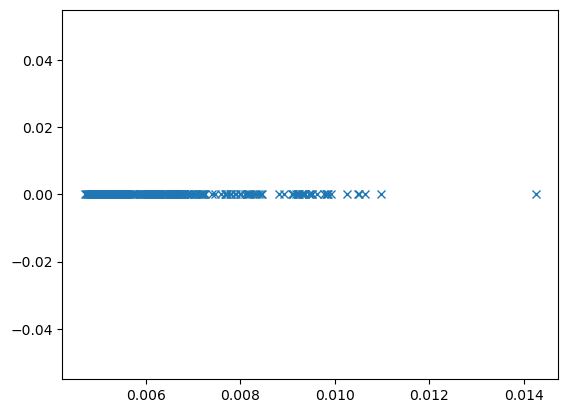

In [35]:
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(total_rec_error_list, np.zeros_like(total_rec_error_list) + val, 'x')
plt.show()

Or displying in a histogram way:

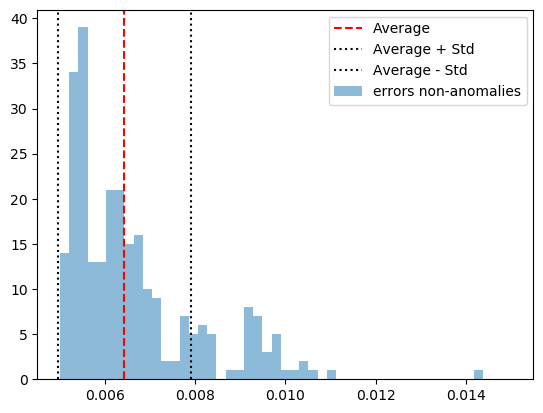

In [36]:
bins = np.linspace(0.005, 0.015, 50)
plt.hist(total_rec_error_list, bins, alpha=0.5, label='errors non-anomalies')
plt.legend(loc='upper right')

# Calculate average and standard deviation
average = np.mean(total_rec_error_list)
std = np.std(total_rec_error_list)

# Plot average line
plt.axvline(x=average, color='red', linestyle='--', label='Average')

# Plot lines for standard deviation
plt.axvline(x=average + std, color='black', linestyle=':', label='Average + Std')
plt.axvline(x=average - std, color='black', linestyle=':', label='Average - Std')

plt.legend()

plt.show()

# Checking the reconstruction of one sample

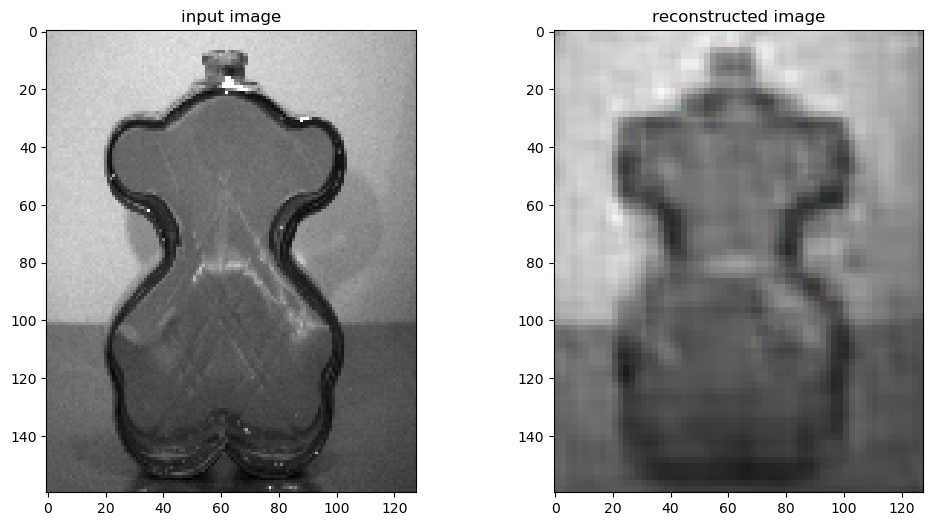

In [37]:
images_in_batch, images_in_batch2 = next(train_crops)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function

single_img  = images_in_batch[0]
single_img = single_img[np.newaxis, :,:,:]
reconstruction = model.predict([[single_img]])

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(single_img[0])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(reconstruction[0])
plt.show()

# Function to check if an image contains anomalies

Based on the previously found histogram, its average and its standard deviation values, it can be built a function that maps the reconstruction error to a probability value of an image being considered as an anomaly or not.

If the a given reconstruction value is outside the range of the standard deviation sum and subtraction to the average values, shown in the plot above, then that reconstruction error has more than 50% chance to be considered as an anomaly image.

In [38]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [40]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

Testing a reconstruction error. Verifying that given some reconstruction error, the probability value is the one we expect. 

In [41]:
print(map_error2prob(na_average_recon_error + na_stdev_recon_error))

49.999999999999986


In [42]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

# Validating the performance of the model with reconstruction error directly

We will use the validation data set to find the best threshold value for predicting an image as anomaly or non-anomaly.

In [43]:
def calc_recon_error_for_val_eval(batch_images,batch_labels):   
    recon_error_list=[]
    labels_list = []
    for im in range(0, batch_images.shape[0]):
        label = batch_labels[im]
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
        labels_list.append(label)
    return recon_error_list, labels_list

In [44]:
total_rec_error_val = []
labels_list = []
for i in range(len(validation_generator)):                               #This will traverse the train generator the number of batches it contains
    images_in_batch, images_labels = next(val_crops_for_threshold)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function
    rec_errors, labels = calc_recon_error_for_val_eval(images_in_batch,images_labels)
    total_rec_error_val.append(rec_errors)
    labels_list.append(labels)
    
print("The list of rec. error contains ", len(total_rec_error_val), "batches of rec. errors")

1/1 [==============================] - 0s 754us/step - loss: 0.0229
The list of rec. error contains  3 batches of rec. errors


In [45]:
total_rec_error_val_list = [item for sublist in total_rec_error_val for item in sublist]
y_true = [item for sublist in labels_list for item in sublist]
print("The reconstruction error list is: ", total_rec_error_val_list)
print("The ground truth labels are: ", y_true)

The reconstruction error list is:  [0.005474373698234558, 0.005269485525786877, 0.00485263392329216, 0.005597015377134085, 0.0053968774154782295, 0.005397987551987171, 0.005361462011933327, 0.005353440064936876, 0.008814473636448383, 0.005842001177370548, 0.006129695102572441, 0.005907914135605097, 0.005509662441909313, 0.006107154302299023, 0.007279188372194767, 0.005093549378216267, 0.005383842624723911, 0.007716386113315821, 0.006068387534469366, 0.009502808563411236, 0.012252893298864365, 0.008266991935670376, 0.022627079859375954, 0.009736644104123116, 0.01139243133366108, 0.011347765102982521, 0.0061588711105287075, 0.014054951258003712, 0.01506799180060625, 0.022867102175951004]
The ground truth labels are:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [46]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, total_rec_error_val_list))

AUC =  0.9700000000000001


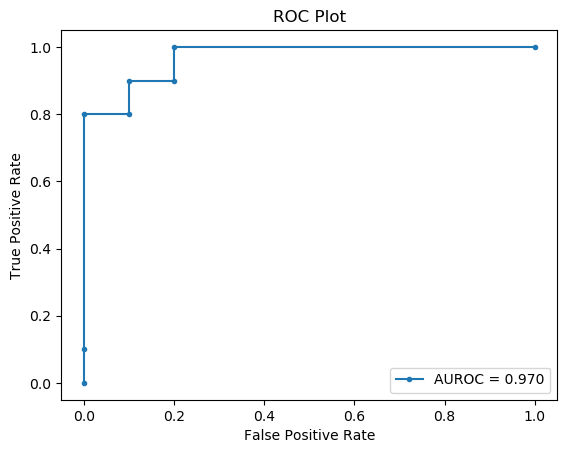

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, total_rec_error_val_list)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, total_rec_error_val_list))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [48]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.  0.  0.  0.1 0.1 0.2 0.2 1. ]
The tpr is:  [0.  0.1 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [1.0228671  0.0228671  0.00973664 0.00881447 0.00826699 0.00727919
 0.00615887 0.00485263]


The best threshold value for this is: 0.00826699 , let's asses this.

In [49]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [50]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [51]:
best_threshold_approach1 = 0.00826699

In [52]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(total_rec_error_val_list, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[18  2]
 [ 1  9]]
The FPR values are:  0.1
The TPR values are:  0.9
Using the threshold =  0.00826699


# Validating the performance of the model with the mapping of the reconstruction error to a probability value

In [53]:
probs_list = map_error2prob_list(total_rec_error_val_list)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [32.3995625965306, 39.35273789689755, 53.49919755710447, 28.23754054160953, 35.029510595452564, 34.991836513724, 36.231383335294716, 36.50361966328878, 80.95154065993437, 19.923594476324656, 10.160286663667875, 17.686743282351465, 31.201988241852114, 10.925241193933202, 28.849423437177173, 45.323384523862096, 35.47186499803048, 43.68635862295702, 12.240847308859426, 100, 100, 62.37196042464974, 100, 100, 100, 100, 9.170156801795915, 100, 100, 100]
The ground truth labels are:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [54]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, probs_list))

AUC =  0.8700000000000001


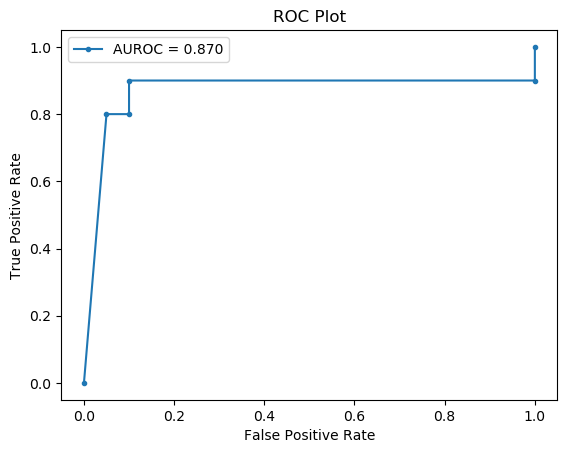

In [55]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, probs_list)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, probs_list))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [56]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.05 0.1  0.1  1.   1.  ]
The tpr is:  [0.  0.8 0.8 0.9 0.9 1. ]
The thresholds are:  [101.         100.          80.95154066  62.37196042  10.16028666
   9.1701568 ]


The best threshold in terms of FPR and TPR is 62.3719604. Let's asses that.

In [57]:
best_threshold_approach2 = 62.3719604

In [58]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list,  best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold =  ", best_threshold_approach2)

[[18  2]
 [ 1  9]]
The FPR values are:  0.1
The TPR values are:  0.9
Using the threshold =   62.3719604


# Evaluating the model. With the threhsold value of the direct reconstruction error

In [59]:
total_rec_error_eval = []
labels_list_eval = []
for i in range(len(test_set_generator)):                               #This will traverse the train generator the number of batches it contains
    images_in_batch, images_labels = next(test_crops)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function
    rec_errors, labels = calc_recon_error_for_val_eval(images_in_batch,images_labels)
    total_rec_error_eval.append(rec_errors)
    labels_list_eval.append(labels)
    
print("The list of rec. error contains ", len(total_rec_error_eval), "batches of rec. errors")

1/1 [==============================] - 0s 693us/step - loss: 0.0150
The list of rec. error contains  3 batches of rec. errors


In [60]:
total_rec_error_eval_list = [item for sublist in total_rec_error_eval for item in sublist]
y_true = [item for sublist in labels_list_eval for item in sublist]
print("The reconstruction error list is: ", total_rec_error_eval_list)
print("The ground truth labels are: ", y_true)

The reconstruction error list is:  [0.005310704465955496, 0.005583964288234711, 0.0055231973528862, 0.006038782186806202, 0.005456531886011362, 0.005086749326437712, 0.006087243091315031, 0.007102906703948975, 0.009337889030575752, 0.008769339881837368, 0.016673004254698753, 0.006332910154014826, 0.007888014428317547, 0.005660177208483219, 0.006002979353070259, 0.006280900444835424, 0.00830625370144844, 0.006659375969320536, 0.00960163027048111, 0.009716713801026344, 0.007961375638842583, 0.01237399596720934, 0.0078722620382905, 0.007165639661252499, 0.009290648624300957, 0.009538533166050911, 0.006197731010615826, 0.0073442356660962105, 0.01142093911767006, 0.014984235167503357]
The ground truth labels are:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [61]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(total_rec_error_eval_list, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[14  6]
 [ 5  5]]
The FPR values are:  0.3
The TPR values are:  0.5
Using the threshold =  0.00826699


In [62]:
def computePredList(probs_list, threshold_value):
    pred = 0
    pred_list =[]
    for i in range (len(probs_list)):
        if probs_list[i] > threshold_value:              # Working with a threshold of 50%
            pred = 1
        else:
            pred = 0
        pred_list.append(pred)
    return pred_list

In [63]:
y_pred = computePredList(total_rec_error_eval_list, best_threshold_approach1)
print("The groudn truth is: ", np.array(y_true))
print("The predicted label is: ", y_pred)

The groudn truth is:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
The predicted label is:  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [64]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [65]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[14  6]
 [ 5  5]]


Text(0.5, 23.52222222222222, 'Predicted label')

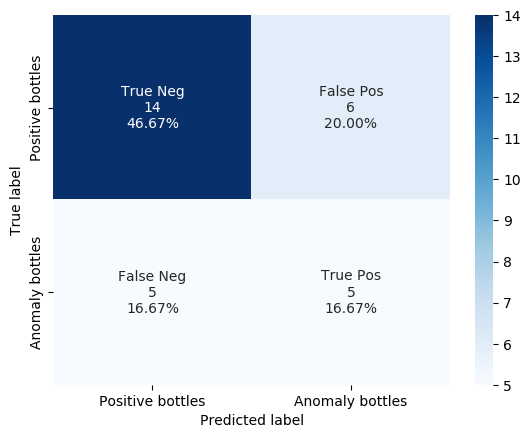

In [66]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [67]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.3
The TPR values are:  0.5


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [68]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.45454545454545453


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [69]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  0.5


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [70]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.7


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [71]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.6333333333333333


## The ROC curve

In [72]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [73]:
auc_score = roc_auc_score(y_true, total_rec_error_eval_list)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, total_rec_error_eval_list)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.760
The fpr is:  [0.   0.05 0.05 0.15 0.15 0.2  0.2  0.3  0.3  0.35 0.35 0.55 0.55 1.  ]
The tpr is:  [0.  0.  0.3 0.3 0.4 0.4 0.5 0.5 0.6 0.6 0.9 0.9 1.  1. ]
The thresholds are:  [1.016673   0.016673   0.01142094 0.00960163 0.00953853 0.00933789
 0.00929065 0.00830625 0.00796138 0.00788801 0.00716564 0.0062809
 0.00619773 0.00508675]


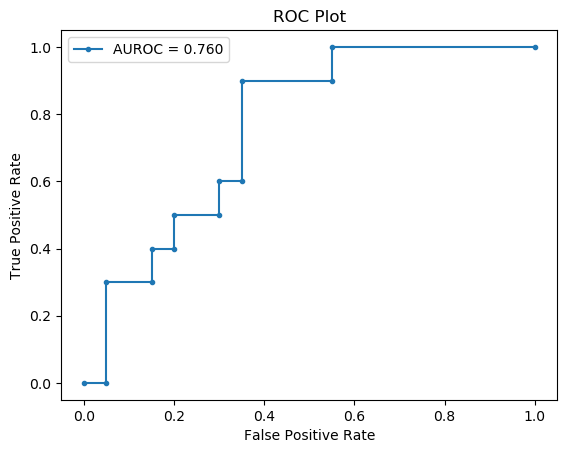

In [74]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Evaluating the model. With the threhsold value computed from a probability value upon the reconstruction errors

In [75]:
probs_list = map_error2prob_list(total_rec_error_eval_list)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [37.953913780971924, 28.680448045219542, 30.74266153903238, 13.245547432205266, 33.00505019780144, 45.55415407733614, 11.600956823392673, 22.867051068332344, 98.71439610835016, 79.41986167610102, 100, 3.2638911349664923, 49.51081274569721, 26.094052801852914, 14.460568173724496, 5.028915542794745, 63.70436500806483, 7.815196624369452, 100, 100, 52.00043111133495, 100, 48.97623269674015, 24.99598434950171, 97.11122486539769, 100, 7.85139010954347, 31.05689706490314, 100, 100]
The ground truth labels are:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [76]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list, best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach2)

[[14  6]
 [ 5  5]]
The FPR values are:  0.3
The TPR values are:  0.5
Using the threshold =  62.3719604


In [77]:
y_pred = computePredList(probs_list, best_threshold_approach2)
print("The groudn truth is: ", np.array(y_true))
print("The predicted label is: ", y_pred)

The groudn truth is:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
The predicted label is:  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [78]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [79]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[14  6]
 [ 5  5]]


Text(0.5, 23.52222222222222, 'Predicted label')

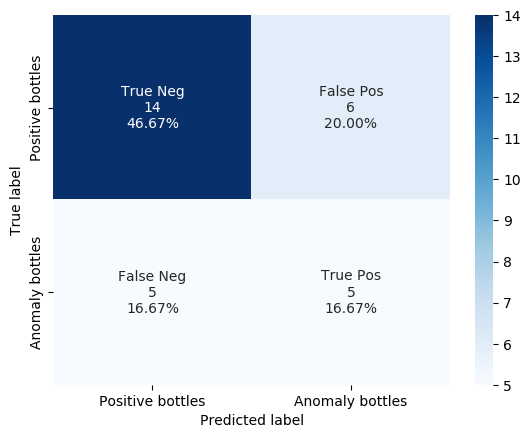

In [80]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [81]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.3
The TPR values are:  0.5


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [82]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.45454545454545453


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [83]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  0.5


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [84]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.7


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [85]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.6333333333333333


## The ROC curve

In [86]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [87]:
auc_score = roc_auc_score(y_true, probs_list)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, probs_list)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.685
The fpr is:  [0.   0.15 0.2  0.2  0.3  0.3  0.35 0.35 0.5  0.5  0.65 0.65 0.85 0.85
 1.  ]
The tpr is:  [0.  0.4 0.4 0.5 0.5 0.6 0.6 0.7 0.7 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [101.         100.          98.71439611  97.11122487  63.70436501
  52.00043111  49.51081275  48.9762327   33.0050502   31.05689706
  26.0940528   24.99598435  11.60095682   7.85139011   3.26389113]


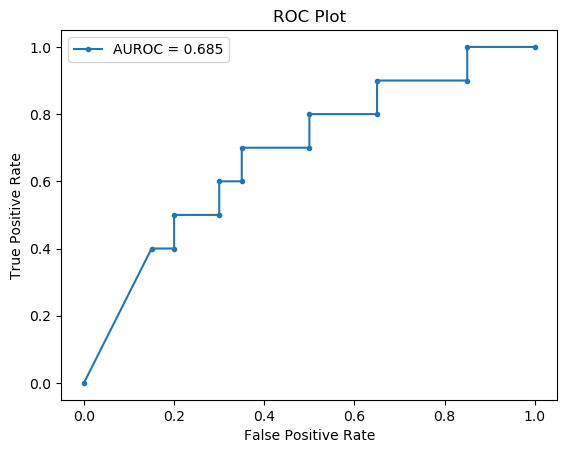

In [88]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()